## Các thư viện cần thiết

In [98]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [99]:
df = pd.read_csv("du_lieu_da_xu_ly.csv",encoding='utf-8')

In [100]:
df.head()

,title,price,ratings,num_rates,screen_size,refresh_rate,chipset,GPU,sim_slot,operating_system,storage_GB,battery_mAh,RAM_in_GB
0,ASUS ROG Phone 6 12GB 256GB,14490000,5.0,20,6.78,120,Qualcomm ® Snapdragon ® 8+ thế hệ 1,Adreno ™ 730,2 SIM (Nano-SIM),Android,256.0,6000,12.0
1,BENCO V91 4GB 128GB,2690000,5.0,1,6.56,90,Unisoc T606,Adreno 610,2 SIM (Nano-SIM),Android,128.0,5000,8.0
2,Benco S1 Pro 8GB 256GB,4290000,5.0,10,6.80,120,Unisoc T616,Mali-G57,2 SIM (Nano-SIM),Android,256.0,5000,16.0
3,INOI 288S 4G,1000000,5.0,1,2.00,120,Apple A18 Pro,Adreno 610,2 SIM (Nano-SIM),Android,192.0,1000,8.0
4,INOI Note 13s 8GB 256GB,2790000,5.0,2,6.95,120,Unisoc T606,Adreno 610,2 SIM (Nano-SIM),Android,256.0,5000,8.0


In [101]:
# Thêm cột brand bằng cách tách tên hãng từ title
df['brand'] = df['title'].apply(lambda x: x.split()[0])

## Thống kê mô tả về giá.

In [102]:
# 4. Thống kê mô tả cơ bản
price_stats = df['price'].describe()

summary_table = pd.DataFrame({
    'Chỉ số thống kê': ['Số lượng quan sát (count)', 'Giá trung bình (mean)', 'Độ lệch chuẩn (std)', 
                        'Giá thấp nhất (min)', 'Phân vị thứ 25 (Q1)', 'Trung vị (median)', 
                        'Phân vị thứ 75 (Q3)', 'Giá cao nhất (max)'],
    'Giá trị (VNĐ)': [
        int(price_stats['count']),
        int(price_stats['mean']),
        int(price_stats['std']),
        int(price_stats['min']),
        int(price_stats['25%']),
        int(price_stats['50%']),
        int(price_stats['75%']),
        int(price_stats['max']),
    ]
})

print("\nTHỐNG KÊ MÔ TẢ CƠ BẢN VỀ GIÁ")
print(summary_table.to_string(index=False))



THỐNG KÊ MÔ TẢ CƠ BẢN VỀ GIÁ
          Chỉ số thống kê  Giá trị (VNĐ)
Số lượng quan sát (count)            283
    Giá trung bình (mean)       11764134
      Độ lệch chuẩn (std)       10854246
      Giá thấp nhất (min)         450000
      Phân vị thứ 25 (Q1)        3625000
        Trung vị (median)        6490000
      Phân vị thứ 75 (Q3)       19490000
       Giá cao nhất (max)       45990000


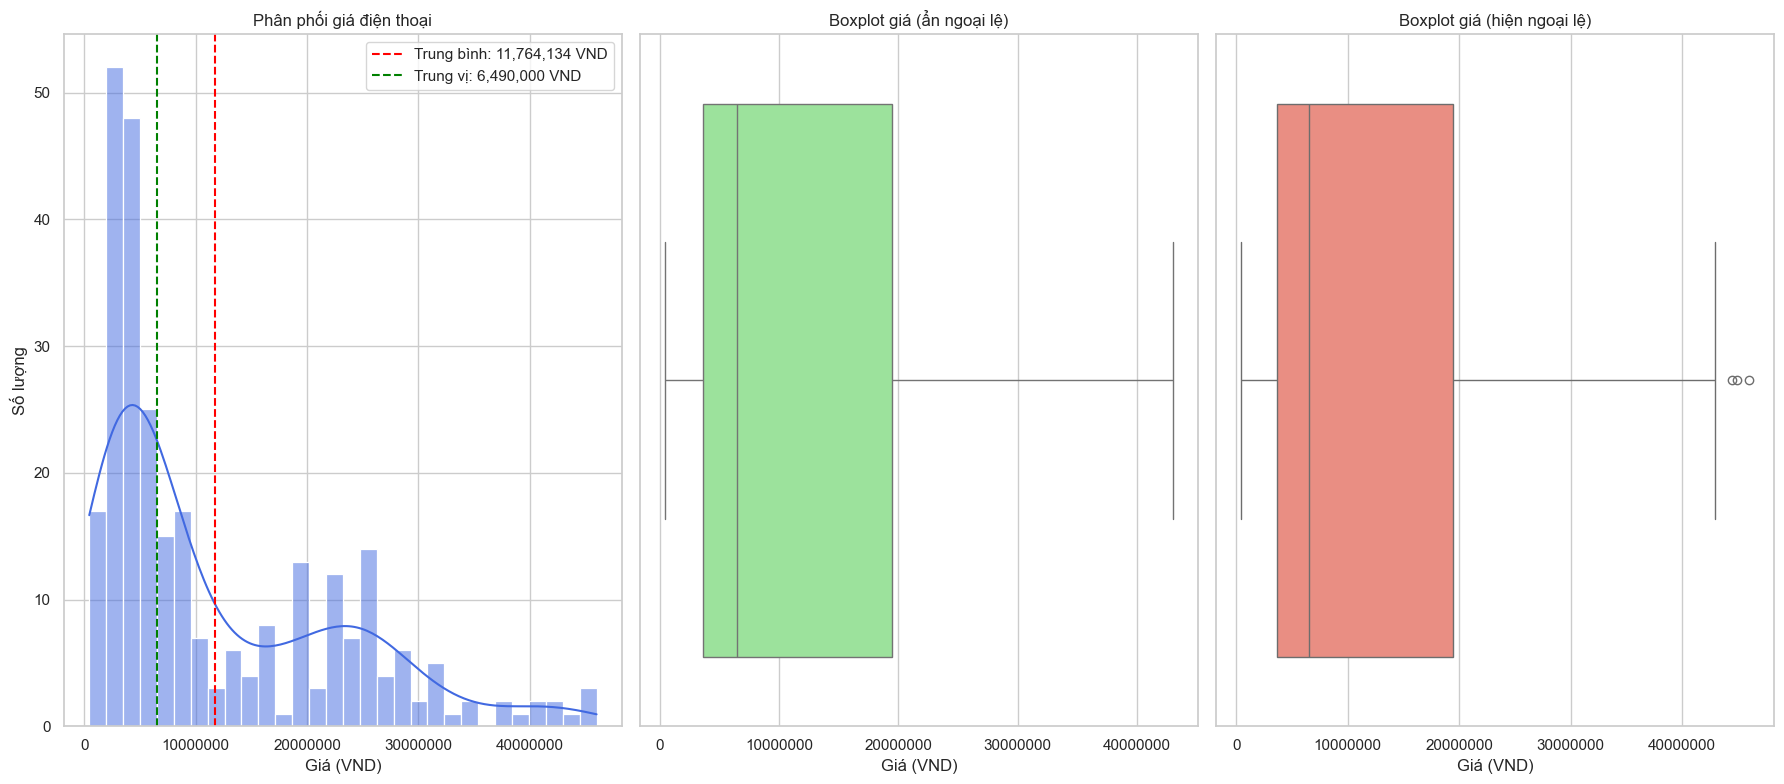

In [103]:
plt.figure(figsize=(18, 8))

# 1. Biểu đồ phân phối giá
plt.subplot(1, 3, 1)
sns.histplot(df['price'], bins=30, kde=True, color='royalblue')
plt.axvline(df['price'].mean(), color='red', linestyle='--', label=f'Trung bình: {df["price"].mean():,.0f} VND')
plt.axvline(df['price'].median(), color='green', linestyle='--', label=f'Trung vị: {df["price"].median():,.0f} VND')
plt.title('Phân phối giá điện thoại')
plt.xlabel('Giá (VND)')
plt.ylabel('Số lượng')
plt.legend()
plt.ticklabel_format(style='plain', axis='x')

# 2. Boxplot không có ngoại lệ (để xem cấu trúc chính)
plt.subplot(1, 3, 2)
sns.boxplot(x=df['price'], showfliers=False, color='lightgreen')
plt.title('Boxplot giá (ẩn ngoại lệ)')
plt.xlabel('Giá (VND)')
plt.ticklabel_format(style='plain', axis='x')

# 3. Boxplot có ngoại lệ (để thấy rõ outliers)
plt.subplot(1, 3, 3)
sns.boxplot(x=df['price'], color='salmon')  # showfliers mặc định = True
plt.title('Boxplot giá (hiện ngoại lệ)')
plt.xlabel('Giá (VND)')
plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()



PHÂN BỐ THEO PHÂN KHÚC GIÁ
price_segment
Dưới 5tr     117
5-15tr        77
15-30tr       70
Trên 30tr     19
Name: count, dtype: int64


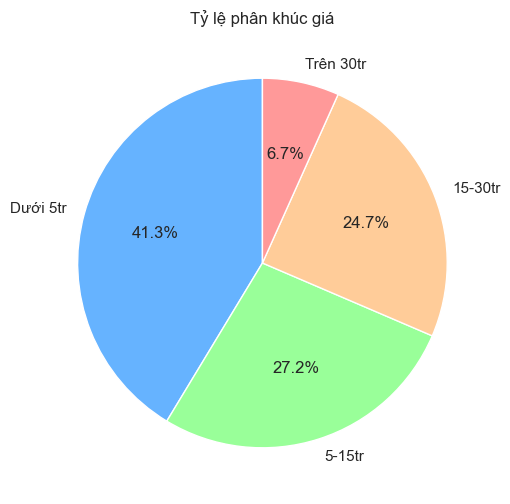

In [104]:
# Phân loại theo phân khúc giá
df['price_segment'] = pd.cut(df['price'], 
                            bins=[0, 5e6, 15e6, 30e6, float('inf')],
                            labels=['Dưới 5tr', '5-15tr', '15-30tr', 'Trên 30tr'])

# Thống kê số lượng theo phân khúc
segment_stats = df['price_segment'].value_counts().sort_index()
print("\nPHÂN BỐ THEO PHÂN KHÚC GIÁ")
print(segment_stats)

# Vẽ biểu đồ phân khúc
plt.figure(figsize=(8, 6))
segment_stats.plot(kind='pie', autopct='%1.1f%%', startangle=90, 
                  colors=['#66b3ff','#99ff99','#ffcc99','#ff9999'])
plt.title('Tỷ lệ phân khúc giá')
plt.ylabel('')
plt.show()

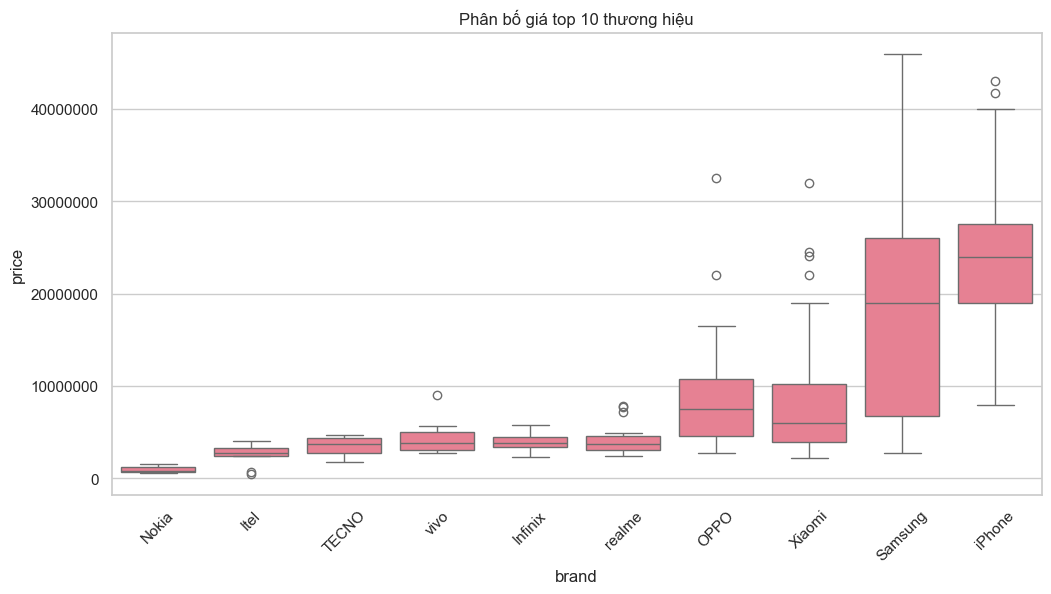

In [105]:
top_brands = df['brand'].value_counts().head(10).index
df_top = df[df['brand'].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='brand', y='price', data=df_top)
plt.title('Phân bố giá top 10 thương hiệu')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

## Thống kê mô tả về RAM.

In [106]:
print(df['RAM_in_GB'].describe())

count    283.000000
mean       8.064212
std        3.367604
min        0.046875
25%        6.000000
50%        8.000000
75%        8.000000
max       28.000000
Name: RAM_in_GB, dtype: float64


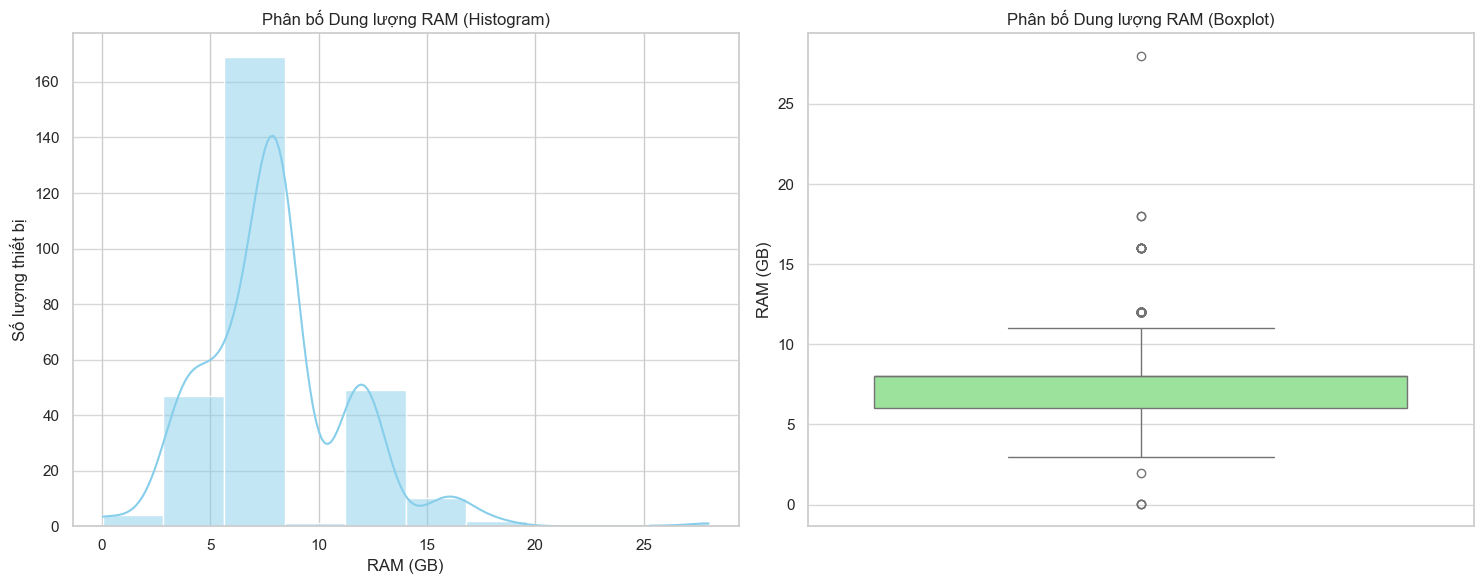

In [107]:
plt.figure(figsize=(15, 6))

# Biểu đồ tần suất (Histogram)
plt.subplot(1, 2, 1) # 1 hàng, 2 cột, biểu đồ thứ nhất
sns.histplot(df['RAM_in_GB'], bins=10, kde=True, color='skyblue')
plt.title('Phân bố Dung lượng RAM (Histogram)')
plt.xlabel('RAM (GB)')
plt.ylabel('Số lượng thiết bị')
plt.grid(axis='y', alpha=0.75)

# Biểu đồ hộp (Boxplot)
plt.subplot(1, 2, 2) # 1 hàng, 2 cột, biểu đồ thứ hai
sns.boxplot(y=df['RAM_in_GB'], color='lightgreen')
plt.title('Phân bố Dung lượng RAM (Boxplot)')
plt.ylabel('RAM (GB)')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout() # Tự động điều chỉnh khoảng cách giữa các biểu đồ
plt.show()

In [108]:
# Đếm tần suất xuất hiện của từng giá trị RAM
ram_counts = df['RAM_in_GB'].value_counts().sort_index()
print("\nCác giá trị RAM và số lượng xuất hiện:")
print(ram_counts)

# In ra các giá trị RAM phổ biến nhất (top 5 chẳng hạn)
print("\nTop 5 giá trị RAM phổ biến nhất:")
print(df['RAM_in_GB'].value_counts().head(5))


Các giá trị RAM và số lượng xuất hiện:
RAM_in_GB
0.046875       1
0.062500       2
2.000000       1
3.000000       4
4.000000      42
5.000000       1
6.000000      40
8.000000     129
11.000000      1
12.000000     49
16.000000     10
18.000000      2
28.000000      1
Name: count, dtype: int64

Top 5 giá trị RAM phổ biến nhất:
RAM_in_GB
8.0     129
12.0     49
4.0      42
6.0      40
16.0     10
Name: count, dtype: int64


## Thống kê mô tả khác.

--- Thống kê mô tả cho các cột số ---
          ratings   num_rates  screen_size  refresh_rate   storage_GB  \
count  283.000000  283.000000   283.000000    283.000000   283.000000   
mean     4.905654   21.257951     6.387032    105.943463   228.583481   
std      0.142557   36.163545     1.040207     21.347438   183.736618   
min      4.000000    1.000000     1.770000     60.000000     0.125000   
25%      4.850000    5.000000     6.500000     90.000000   128.000000   
50%      5.000000   10.000000     6.670000    120.000000   192.000000   
75%      5.000000   21.000000     6.715000    120.000000   256.000000   
max      5.000000  287.000000     7.820000    144.000000  1024.000000   

       battery_mAh  
count   283.000000  
mean   4648.618375  
std     965.610215  
min     800.000000  
25%    4655.000000  
50%    5000.000000  
75%    5000.000000  
max    7000.000000  




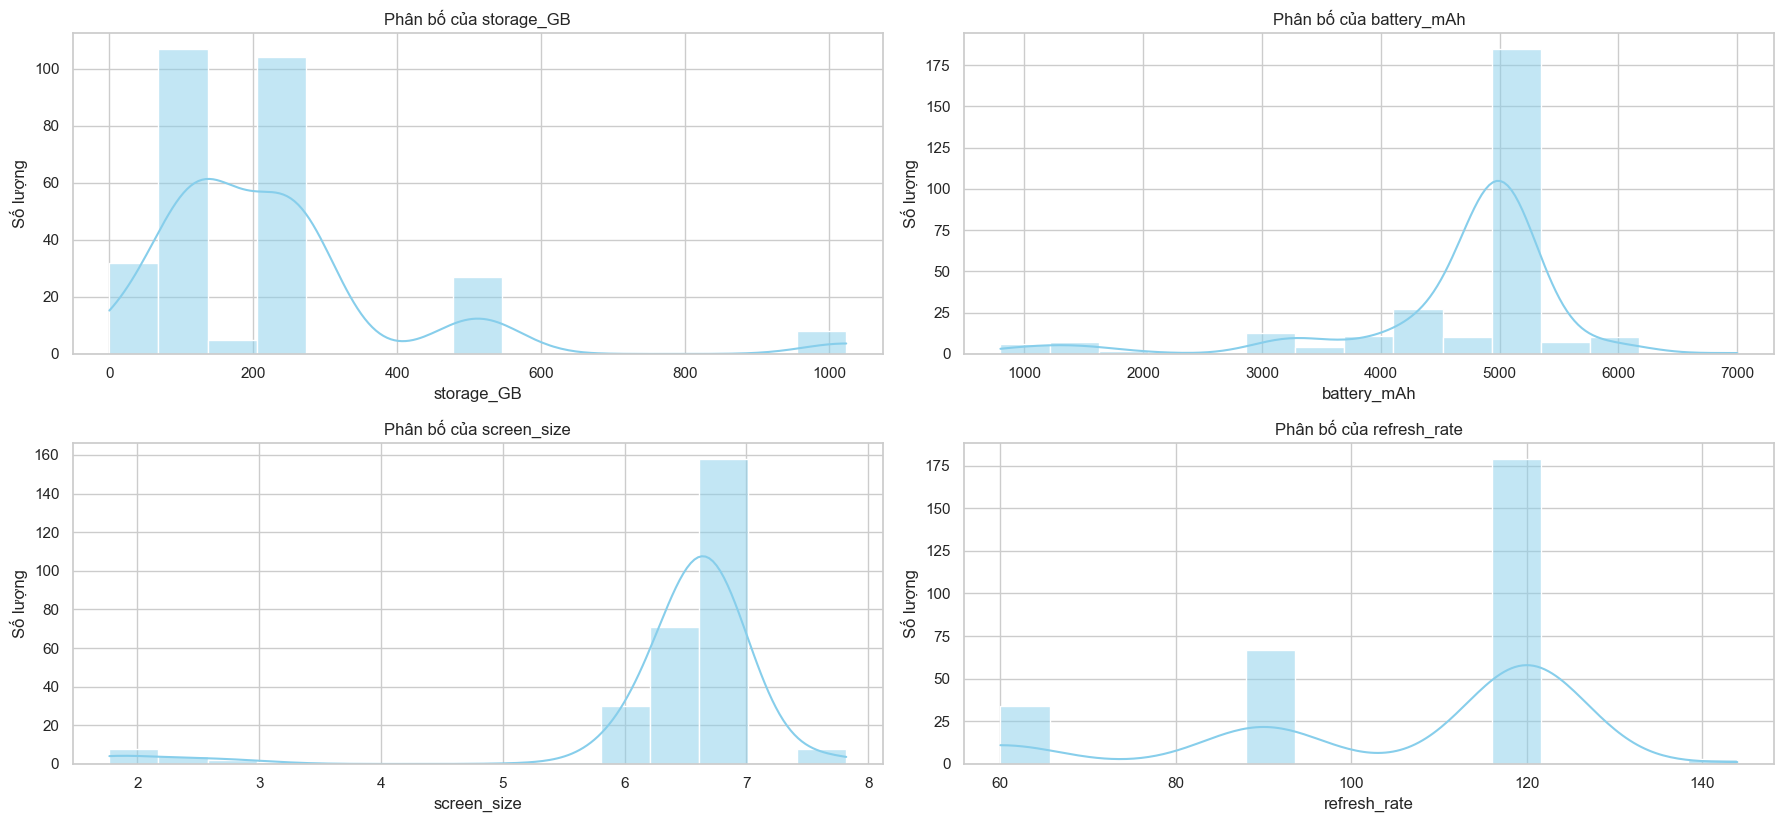

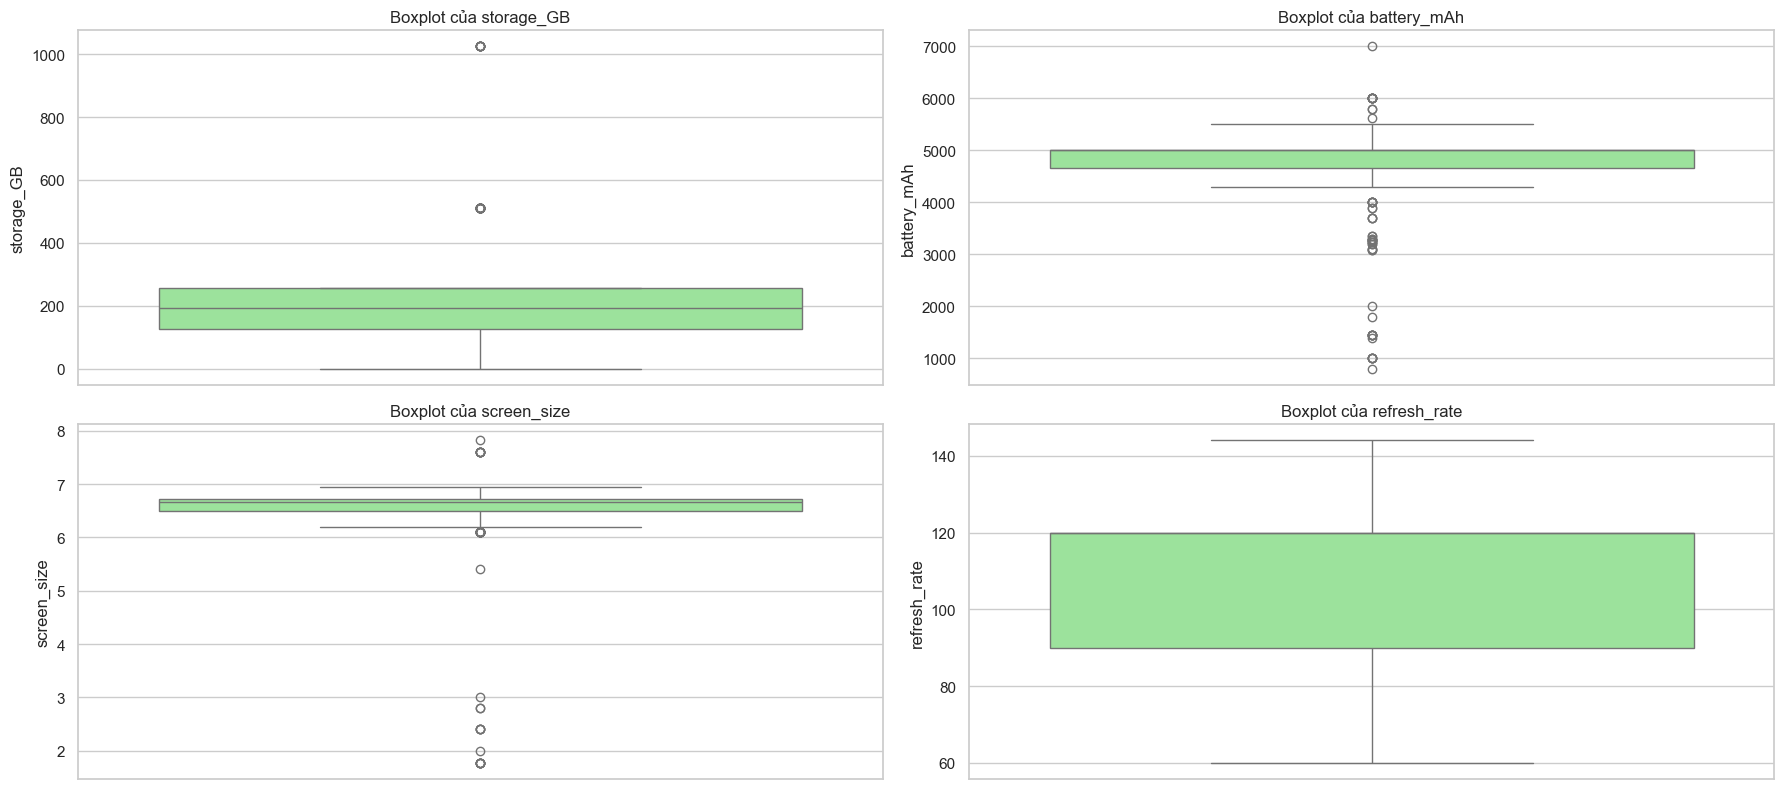

In [109]:
print("--- Thống kê mô tả cho các cột số ---")
print(df[['ratings', 'num_rates', 'screen_size', 'refresh_rate', 'storage_GB', 'battery_mAh']].describe())
print("\n")

# --- 3. Trực quan hóa Phân bố Dữ liệu Số ---
numeric_features = ['storage_GB', 'battery_mAh', 'screen_size', 'refresh_rate']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 2, i + 1) # 3 hàng, 2 cột
    sns.histplot(df[feature], bins=15, kde=True, color='skyblue')
    plt.title(f'Phân bố của {feature}')
    plt.xlabel(feature)
    plt.ylabel('Số lượng')
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 12))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(y=df[feature], color='lightgreen')
    plt.title(f'Boxplot của {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()



--- Phân tích tần suất cho các cột phân loại ---

--- Tần suất của chipset ---
chipset
Apple A18 Pro                               13
Snapdragon 8 Elite dành cho Galaxy (3nm)     7
Unisoc T606                                  7
MediaTek Helio G85 8 nhân                    7
Unisoc T107                                  6
                                            ..
Snapdragon 680 4G (6 nm)                     1
MediaTek Dimensity 7050 5G 8 nhân            1
Mediatek Dimensity 7050 (6 nm)               1
MediaTek Dimensity 7050                      1
MediaTek Helio G99-Ultra                     1
Name: count, Length: 151, dtype: int64


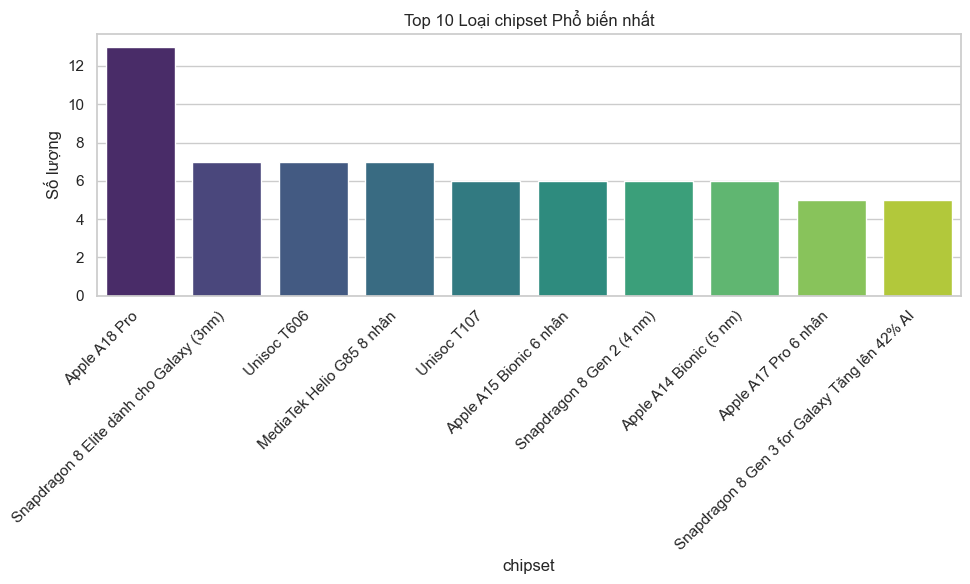


--- Tần suất của sim_slot ---
sim_slot
2 SIM (Nano-SIM)                                156
2 SIM (nano‑SIM và eSIM)                         43
2 Nano-SIM                                       23
Sim kép (nano-Sim và e-Sim) - Hỗ trợ 2 e-Sim     19
SIM 1 + SIM 2 / SIM 1 + eSIM / 2 eSIM            12
2 Nano SIM hoặc 1 Nano + 1 eSIM                   9
2 Nano-SIM + eSIM                                 8
Nano-SIM                                          3
Nano-SIM + eSIM                                   3
Micro-SIM + Nano SIM                              2
Dual nano-SIM hoặc 1 nano-SIM + 1 eSIM            2
1 Nano SIM + 1 eSIM hoặc 2 eSIM                   2
Micro-SIM                                         1
Name: count, dtype: int64


C:\Users\trinh\AppData\Local\Temp\ipykernel_10488\553184079.py:19: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
C:\Users\trinh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


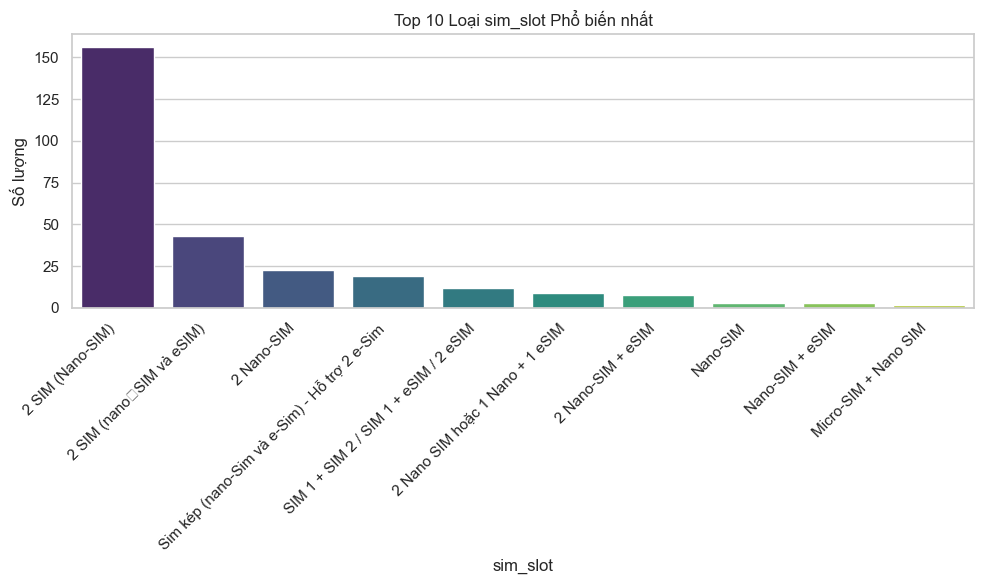


--- Tần suất của operating_system ---
operating_system
Android    225
iOS         49
Khác         6
S30+         3
Name: count, dtype: int64


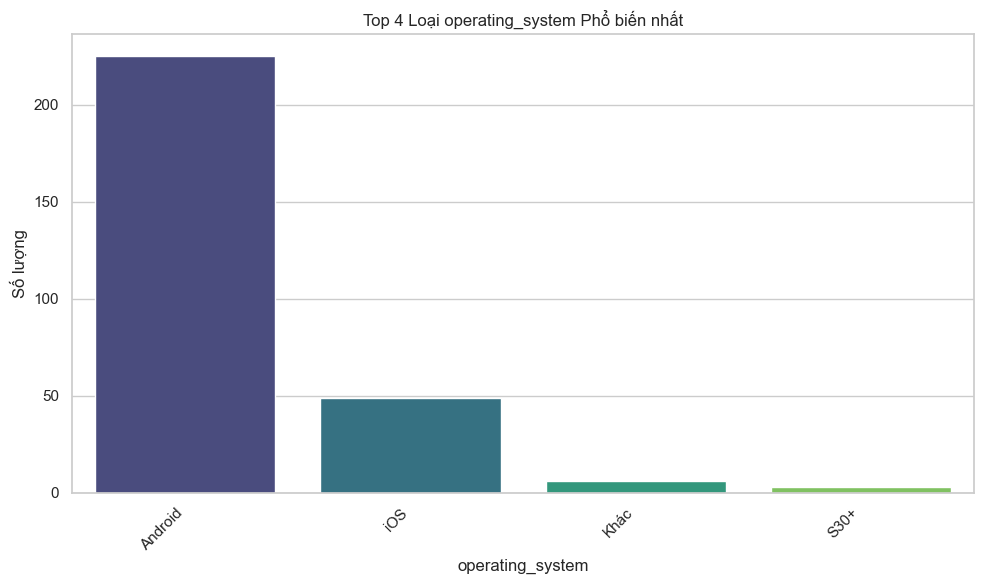


--- Phân tích mối quan hệ ---


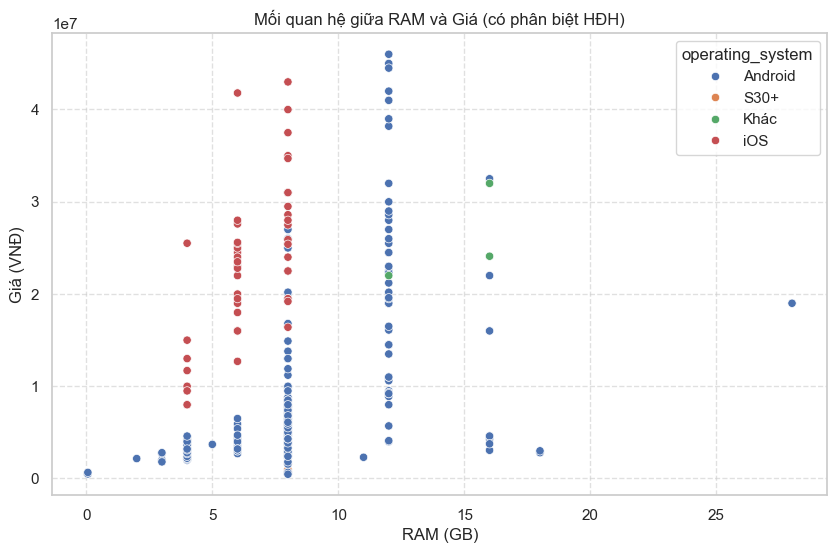

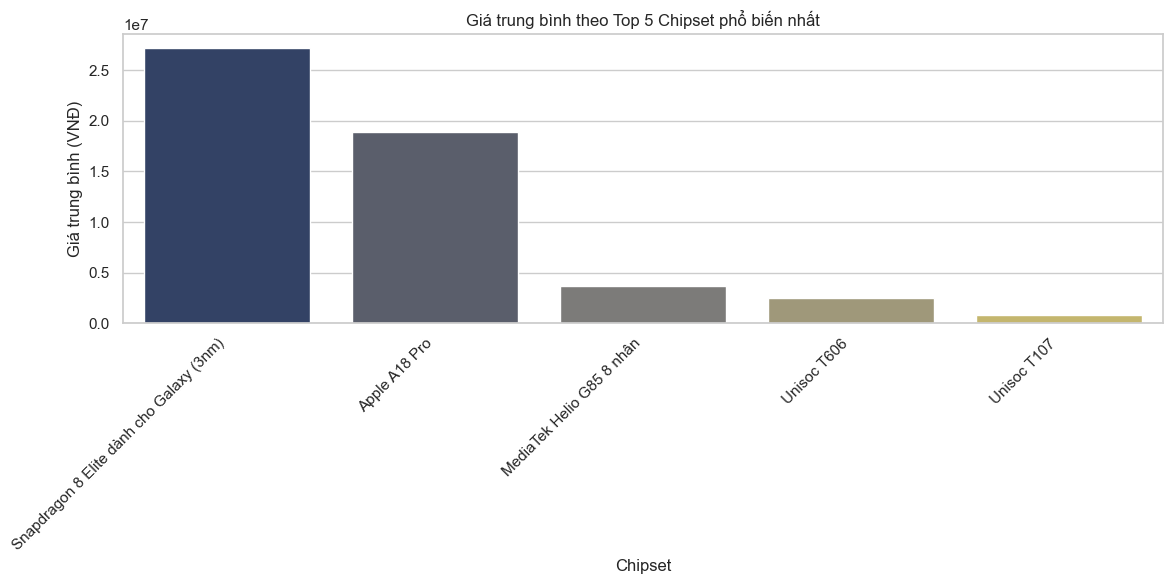

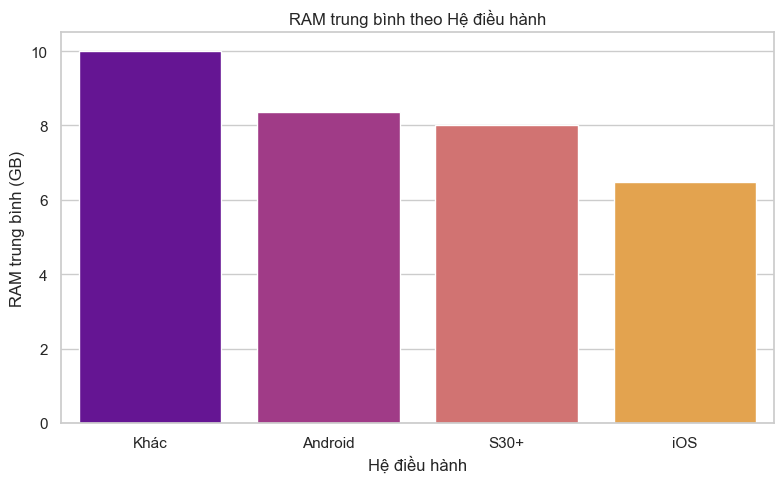

In [110]:
# --- 4. Phân tích Tần suất cho các Cột Phân loại ---
# Điều chỉnh tên cột GPU nếu cần, trong ảnh là một phần của chipset và sim_slot
# Trong dữ liệu mẫu của tôi, 'GPU' được tạo riêng, nếu của bạn nó là phần của cột khác thì bạn phải xử lý để tách nó ra
categorical_features = ['chipset', 'sim_slot', 'operating_system'] # Loại bỏ 'GPU' vì nó nằm trong 'chipset' hoặc 'sim_slot' trong hình ảnh

print("\n--- Phân tích tần suất cho các cột phân loại ---")
for feature in categorical_features:
    print(f"\n--- Tần suất của {feature} ---")
    print(df[feature].value_counts())
    
    # Trực quan hóa tần suất (Top 10 nếu có quá nhiều danh mục)
    plt.figure(figsize=(10, 6))
    top_categories = df[feature].value_counts().head(10)
    sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')
    plt.title(f'Top {len(top_categories)} Loại {feature} Phổ biến nhất')
    plt.xlabel(feature)
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- 5. Phân tích mối quan hệ đơn giản (một vài ví dụ) ---

print("\n--- Phân tích mối quan hệ ---")

# Mối quan hệ giữa RAM và Giá
plt.figure(figsize=(10, 6))
sns.scatterplot(x='RAM_in_GB', y='price', data=df, hue='operating_system', palette='deep')
plt.title('Mối quan hệ giữa RAM và Giá (có phân biệt HĐH)')
plt.xlabel('RAM (GB)')
plt.ylabel('Giá (VNĐ)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# So sánh giá trung bình theo loại Chipset (Top 5 Chipset)
plt.figure(figsize=(12, 6))
# Lấy top 5 chipset phổ biến nhất trước khi tính trung bình để tránh quá nhiều danh mục
top_5_chipsets = df['chipset'].value_counts().head(5).index
df_filtered_chipset = df[df['chipset'].isin(top_5_chipsets)]
avg_price_by_chipset = df_filtered_chipset.groupby('chipset')['price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_by_chipset.index, y=avg_price_by_chipset.values, palette='cividis')
plt.title('Giá trung bình theo Top 5 Chipset phổ biến nhất')
plt.xlabel('Chipset')
plt.ylabel('Giá trung bình (VNĐ)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# So sánh RAM trung bình theo Hệ điều hành
plt.figure(figsize=(8, 5))
avg_ram_by_os = df.groupby('operating_system')['RAM_in_GB'].mean().sort_values(ascending=False)
sns.barplot(x=avg_ram_by_os.index, y=avg_ram_by_os.values, palette='plasma')
plt.title('RAM trung bình theo Hệ điều hành')
plt.xlabel('Hệ điều hành')
plt.ylabel('RAM trung bình (GB)')
plt.tight_layout()
plt.show()

## Huấn luyện và đánh giá mô hình

Kích thước tập huấn luyện X_train: (226, 10)
Kích thước tập kiểm tra X_test: (57, 10)


--- Bắt đầu huấn luyện mô hình Random Forest Regressor với dữ liệu chuẩn hóa ---
--- Huấn luyện mô hình hoàn tất! ---


--- Đánh giá hiệu suất mô hình với dữ liệu chuẩn hóa ---
Mean Absolute Error (MAE) (Standardized): 3,010,487.72
Mean Squared Error (MSE) (Standardized): 24,044,014,695,789.47
Root Mean Squared Error (RMSE) (Standardized): 4,903,469.66
R-squared (R2) (Standardized): 0.8171


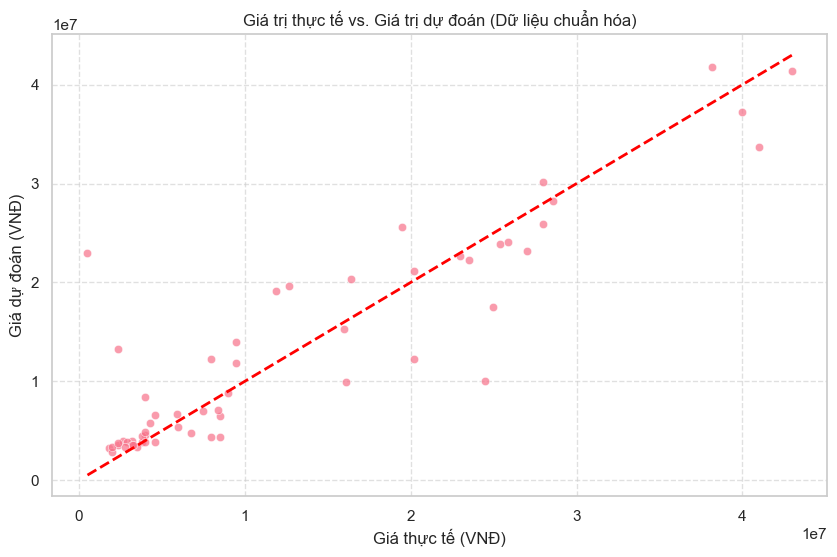


--- Độ quan trọng của các đặc trưng (Feature Importance) (Dữ liệu chuẩn hóa) ---
                               Feature  Importance
142          sim_slot_2 SIM (Nano-SIM)    0.391039
140                sim_slot_2 Nano-SIM    0.174100
4                           storage_GB    0.129584
2                          screen_size    0.092265
6                            RAM_in_GB    0.035994
1                            num_rates    0.020420
5                          battery_mAh    0.018759
146                  sim_slot_Nano-SIM    0.013878
143  sim_slot_2 SIM (nano‑SIM và eSIM)    0.011320
150           operating_system_Android    0.010563


C:\Users\trinh\AppData\Local\Temp\ipykernel_10488\632998616.py:80: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
C:\Users\trinh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


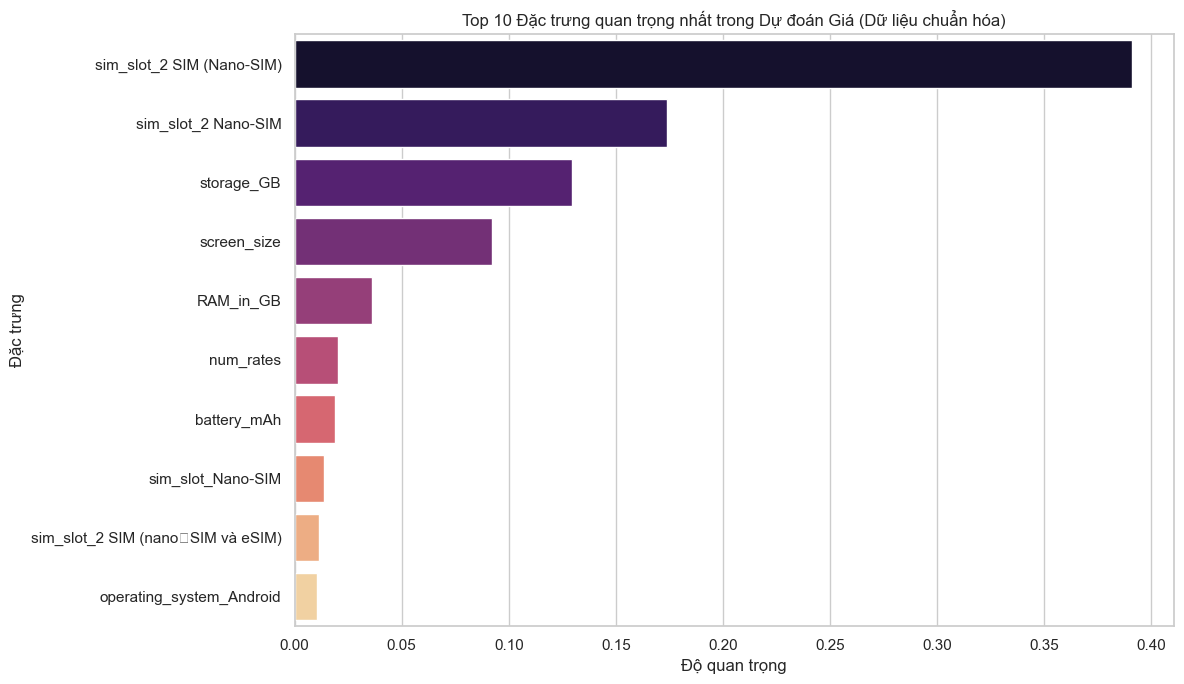

In [111]:
# --- 2. Chọn Biến Độc lập (Features) và Biến Phụ thuộc (Target) ---
target = 'price'
numerical_features = ['ratings', 'num_rates', 'screen_size', 'refresh_rate', 'storage_GB', 'battery_mAh', 'RAM_in_GB']
categorical_features = ['chipset', 'sim_slot', 'operating_system']

X = df[numerical_features + categorical_features]
y = df[target]

# --- 3. Chia dữ liệu thành tập huấn luyện và tập kiểm tra ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Kích thước tập huấn luyện X_train: {X_train.shape}")
print(f"Kích thước tập kiểm tra X_test: {X_test.shape}")
print("\n")

# --- 4. Xây dựng Pipeline với Chuẩn hóa và Huấn luyện Mô hình ---
# Xác định các bước tiền xử lý
# 'num' cho StandardScaler, 'cat' cho OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Xây dựng Pipeline
model_standardized = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

print("--- Bắt đầu huấn luyện mô hình Random Forest Regressor với dữ liệu chuẩn hóa ---")
model_standardized.fit(X_train, y_train)
print("--- Huấn luyện mô hình hoàn tất! ---")
print("\n")

# --- 5. Đánh giá Hiệu suất Mô hình ---
print("--- Đánh giá hiệu suất mô hình với dữ liệu chuẩn hóa ---")
y_pred_standardized = model_standardized.predict(X_test)

mae_std = mean_absolute_error(y_test, y_pred_standardized)
mse_std = mean_squared_error(y_test, y_pred_standardized)
rmse_std = np.sqrt(mse_std)
r2_std = r2_score(y_test, y_pred_standardized)

print(f"Mean Absolute Error (MAE) (Standardized): {mae_std:,.2f}")
print(f"Mean Squared Error (MSE) (Standardized): {mse_std:,.2f}")
print(f"Root Mean Squared Error (RMSE) (Standardized): {rmse_std:,.2f}")
print(f"R-squared (R2) (Standardized): {r2_std:.4f}")

# Trực quan hóa kết quả dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_standardized, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Giá trị thực tế vs. Giá trị dự đoán (Dữ liệu chuẩn hóa)')
plt.xlabel('Giá thực tế (VNĐ)')
plt.ylabel('Giá dự đoán (VNĐ)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Phân tích độ quan trọng của các đặc trưng (Feature Importance)
feature_importances_std = model_standardized.named_steps['regressor'].feature_importances_

# Lấy tên cột sau khi tiền xử lý
# Numerical features vẫn giữ nguyên tên
# Categorical features sẽ có tên mới từ OneHotEncoder
numerical_feature_names = numerical_features # Tên của các cột số không thay đổi
onehot_feature_names = model_standardized.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names_std = list(numerical_feature_names) + list(onehot_feature_names)


importance_df_std = pd.DataFrame({'Feature': all_feature_names_std, 'Importance': feature_importances_std})
importance_df_std = importance_df_std.sort_values(by='Importance', ascending=False)

print("\n--- Độ quan trọng của các đặc trưng (Feature Importance) (Dữ liệu chuẩn hóa) ---")
print(importance_df_std.head(10))

plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df_std.head(10), palette='magma')
plt.title('Top 10 Đặc trưng quan trọng nhất trong Dự đoán Giá (Dữ liệu chuẩn hóa)')
plt.xlabel('Độ quan trọng')
plt.ylabel('Đặc trưng')
plt.tight_layout()
plt.show()

--- CHÚ Ý: Để đơn giản hóa việc code tay Decision Tree, chúng ta sẽ chỉ sử dụng các đặc trưng số. ---
--- Việc xử lý các đặc trưng phân loại đã được One-Hot Encoding trong mô hình code tay sẽ phức tạp hơn. ---
Kích thước tập huấn luyện (đặc trưng số): (226, 7)
Kích thước tập kiểm tra (đặc trưng số): (57, 7)


--- Bắt đầu huấn luyện mô hình Cây Quyết định Hồi quy (code tay) ---
--- Huấn luyện mô hình Cây Quyết định Hồi quy hoàn tất! ---


--- Đánh giá hiệu suất mô hình Cây Quyết định Hồi quy (code tay) ---
Mean Absolute Error (MAE) (Cây Quyết định code tay): 5,143,877.57
Mean Squared Error (MSE) (Cây Quyết định code tay): 59,006,501,408,309.41
Root Mean Squared Error (RMSE) (Cây Quyết định code tay): 7,681,568.94
R-squared (R2) (Cây Quyết định code tay): 0.5512


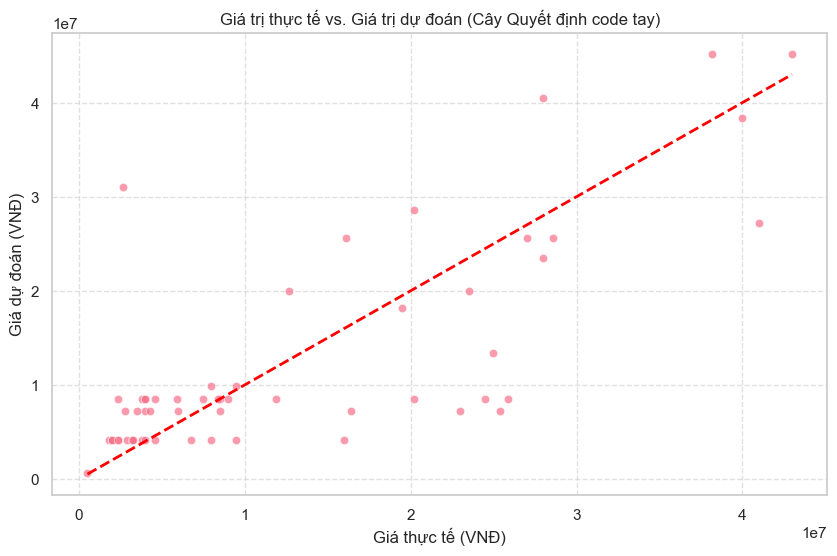

In [112]:
# --- 2. Chọn Biến Độc lập (Features) và Biến Phụ thuộc (Target) ---
target = 'price'
numerical_features = ['ratings', 'num_rates', 'screen_size', 'refresh_rate', 'storage_GB', 'battery_mAh', 'RAM_in_GB']
categorical_features = ['chipset', 'sim_slot', 'operating_system']

X = df[numerical_features + categorical_features]
y = df[target]

# --- 3. Tiền xử lý (One-Hot Encoding cho categorical, Standard Scaling cho numerical) ---
# Tên các cột sau khi One-Hot Encoding là cần thiết để hiểu kết quả dự đoán
all_features_before_processing = numerical_features + categorical_features

# Tạo ColumnTransformer cho One-Hot Encoding và Standard Scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Giữ nguyên các cột khác nếu có
)

# Áp dụng tiền xử lý cho toàn bộ X trước khi chia để lấy được tên cột đầy đủ
# Lưu ý: Đây là bước duy nhất chúng ta xử lý trên toàn bộ X
# Để tránh rò rỉ dữ liệu trong huấn luyện mô hình, việc fit scaler/encoder
# phải được thực hiện trên tập huấn luyện sau khi chia.
# Tuy nhiên, để lấy được all_transformed_feature_names một cách dễ dàng,
# chúng ta có thể fit_transform một lần trên X_temp (tạm thời)
# hoặc lấy tên các cột sau khi fit encoder riêng rẽ trên X_train.
# Để đơn giản cho việc code tay, chúng ta sẽ xử lý thủ công hơn một chút.

# Để tránh phức tạp quá mức khi code tay, chúng ta sẽ chỉ sử dụng các đặc trưng số.
# Việc code tay Decision Tree với các đặc trưng phân loại (đã được One-Hot Encoding)
# đòi hỏi logic xử lý đặc trưng phức tạp hơn trong hàm _find_best_split,
# vì chúng là các đặc trưng nhị phân (0 hoặc 1).
# Để tập trung vào core concept của Decision Tree Regressor, chúng ta chỉ sử dụng các đặc trưng số.

print("--- CHÚ Ý: Để đơn giản hóa việc code tay Decision Tree, chúng ta sẽ chỉ sử dụng các đặc trưng số. ---")
print("--- Việc xử lý các đặc trưng phân loại đã được One-Hot Encoding trong mô hình code tay sẽ phức tạp hơn. ---")

X_numeric = X[numerical_features]

# --- 4. Chia dữ liệu thành tập huấn luyện và tập kiểm tra (chỉ các đặc trưng số) ---
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# --- 5. Chuẩn hóa dữ liệu số sau khi chia (để tránh rò rỉ dữ liệu) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

# Chuyển đổi lại thành DataFrame để giữ tên cột cho dễ đọc
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_features, index=X_train_num.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_features, index=X_test_num.index)

print(f"Kích thước tập huấn luyện (đặc trưng số): {X_train_scaled_df.shape}")
print(f"Kích thước tập kiểm tra (đặc trưng số): {X_test_scaled_df.shape}")
print("\n")


# --- PHẦN CODE TAY CÂY QUYẾT ĐỊNH HỒI QUY ---

class Node:
    """
    Lớp Node đại diện cho một nút trong cây quyết định.
    """
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        self.feature_idx = feature_idx  # Chỉ số của đặc trưng để phân tách (nếu không phải là lá)
        self.threshold = threshold      # Ngưỡng phân tách (nếu không phải là lá)
        self.left = left                # Nút con bên trái (nhỏ hơn hoặc bằng ngưỡng)
        self.right = right              # Nút con bên phải (lớn hơn ngưỡng)
        self.value = value              # Giá trị dự đoán nếu đây là nút lá (trung bình của y)

class MyDecisionTreeRegressor:
    """
    Triển khai cây quyết định cho bài toán hồi quy từ đầu.
    """
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None # Gốc của cây

    def _mse(self, y):
        """
        Tính toán Mean Squared Error (MSE) cho một mảng các giá trị mục tiêu y.
        Đối với hồi quy, đây là tiêu chí để đánh giá độ "thuần khiết" của một nút.
        """
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y))**2)

    def _find_best_split(self, X, y):
        """
        Tìm đặc trưng và ngưỡng tốt nhất để phân tách dữ liệu.
        Trả về: (chỉ số đặc trưng, ngưỡng tốt nhất, MSE thấp nhất)
        """
        best_mse = float('inf')
        best_feature_idx = None
        best_threshold = None

        n_samples, n_features = X.shape

        # Nếu số lượng mẫu quá ít để phân tách, không cần tìm chia
        if n_samples < self.min_samples_split:
            return None, None, None

        # Tính MSE của nút hiện tại (trước khi chia)
        current_mse = self._mse(y)

        # Duyệt qua từng đặc trưng
        for feature_idx in range(n_features):
            unique_values = np.unique(X[:, feature_idx]) # Lấy các giá trị độc nhất của đặc trưng

            # Duyệt qua từng giá trị có thể làm ngưỡng (lấy trung bình của 2 giá trị liên tiếp)
            for i in range(len(unique_values) - 1):
                threshold = (unique_values[i] + unique_values[i+1]) / 2

                # Chia dữ liệu dựa trên ngưỡng
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold

                y_left, y_right = y[left_indices], y[right_indices]

                # Nếu một bên không có mẫu, thì đây không phải là một phân tách hợp lệ
                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                # Tính MSE cho các nhóm con
                mse_left = self._mse(y_left)
                mse_right = self._mse(y_right)

                # Tính MSE có trọng số cho phân tách
                # Phương sai có trọng số = (số mẫu trái * MSE trái + số mẫu phải * MSE phải) / tổng mẫu
                weighted_mse = (len(y_left) * mse_left + len(y_right) * mse_right) / n_samples

                # Cập nhật nếu tìm thấy phân tách tốt hơn
                if weighted_mse < best_mse:
                    best_mse = weighted_mse
                    best_feature_idx = feature_idx
                    best_threshold = threshold

        return best_feature_idx, best_threshold, best_mse

    def _build_tree(self, X, y, depth=0):
        """
        Hàm đệ quy để xây dựng cây.
        """
        # Điều kiện dừng:
        # 1. Nếu không có mẫu nào
        # 2. Nếu tất cả các giá trị y trong nút đều giống nhau (MSE = 0)
        # 3. Nếu đạt đến độ sâu tối đa
        # 4. Nếu số lượng mẫu nhỏ hơn min_samples_split
        if len(y) == 0:
            return Node(value=0) # Hoặc np.nan, tùy vào cách bạn muốn xử lý

        if len(np.unique(y)) == 1 or depth == self.max_depth or \
           len(y) < self.min_samples_split:
            return Node(value=np.mean(y)) # Đây là nút lá, giá trị dự đoán là trung bình của y

        # Tìm phân tách tốt nhất
        feature_idx, threshold, current_mse = self._find_best_split(X, y)

        # Nếu không tìm thấy phân tách tốt hơn (ví dụ: chỉ có 1 mẫu, hoặc tất cả các giá trị đặc trưng giống nhau)
        if feature_idx is None:
            return Node(value=np.mean(y)) # Trở thành nút lá

        # Chia dữ liệu
        left_indices = X[:, feature_idx] <= threshold
        right_indices = X[:, feature_idx] > threshold

        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]

        # Đệ quy xây dựng cây con
        left_child = self._build_tree(X_left, y_left, depth + 1)
        right_child = self._build_tree(X_right, y_right, depth + 1)

        return Node(feature_idx, threshold, left_child, right_child)

    def fit(self, X, y):
        """
        Huấn luyện cây quyết định.
        X: Mảng numpy của các đặc trưng huấn luyện.
        y: Mảng numpy của các giá trị mục tiêu.
        """
        # Đảm bảo X là numpy array để dễ dàng lập chỉ mục
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y.values if isinstance(y, pd.Series) else y

        self.tree = self._build_tree(X, y, depth=0)

    def _predict_single(self, x, node):
        """
        Hàm đệ quy để dự đoán giá trị cho một mẫu x duy nhất.
        """
        if node.value is not None: # Nếu là nút lá
            return node.value

        if x[node.feature_idx] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)

    def predict(self, X):
        """
        Dự đoán giá trị cho một tập hợp các mẫu.
        X: Mảng numpy của các đặc trưng cần dự đoán.
        """
        # Đảm bảo X là numpy array
        X = X.values if isinstance(X, pd.DataFrame) else X

        predictions = []
        for x in X:
            predictions.append(self._predict_single(x, self.tree))
        return np.array(predictions)

# --- HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH CODE TAY ---

print("--- Bắt đầu huấn luyện mô hình Cây Quyết định Hồi quy (code tay) ---")
# Khởi tạo và huấn luyện mô hình
my_dt_regressor = MyDecisionTreeRegressor(max_depth=5, min_samples_split=5) # Thử các tham số khác nhau
my_dt_regressor.fit(X_train_scaled_df, y_train)
print("--- Huấn luyện mô hình Cây Quyết định Hồi quy hoàn tất! ---")
print("\n")

print("--- Đánh giá hiệu suất mô hình Cây Quyết định Hồi quy (code tay) ---")
y_pred_my_dt = my_dt_regressor.predict(X_test_scaled_df)

mae_my_dt = mean_absolute_error(y_test, y_pred_my_dt)
mse_my_dt = mean_squared_error(y_test, y_pred_my_dt)
rmse_my_dt = np.sqrt(mse_my_dt)
r2_my_dt = r2_score(y_test, y_pred_my_dt)

print(f"Mean Absolute Error (MAE) (Cây Quyết định code tay): {mae_my_dt:,.2f}")
print(f"Mean Squared Error (MSE) (Cây Quyết định code tay): {mse_my_dt:,.2f}")
print(f"Root Mean Squared Error (RMSE) (Cây Quyết định code tay): {rmse_my_dt:,.2f}")
print(f"R-squared (R2) (Cây Quyết định code tay): {r2_my_dt:.4f}")

# Trực quan hóa kết quả dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_my_dt, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Giá trị thực tế vs. Giá trị dự đoán (Cây Quyết định code tay)')
plt.xlabel('Giá thực tế (VNĐ)')
plt.ylabel('Giá dự đoán (VNĐ)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


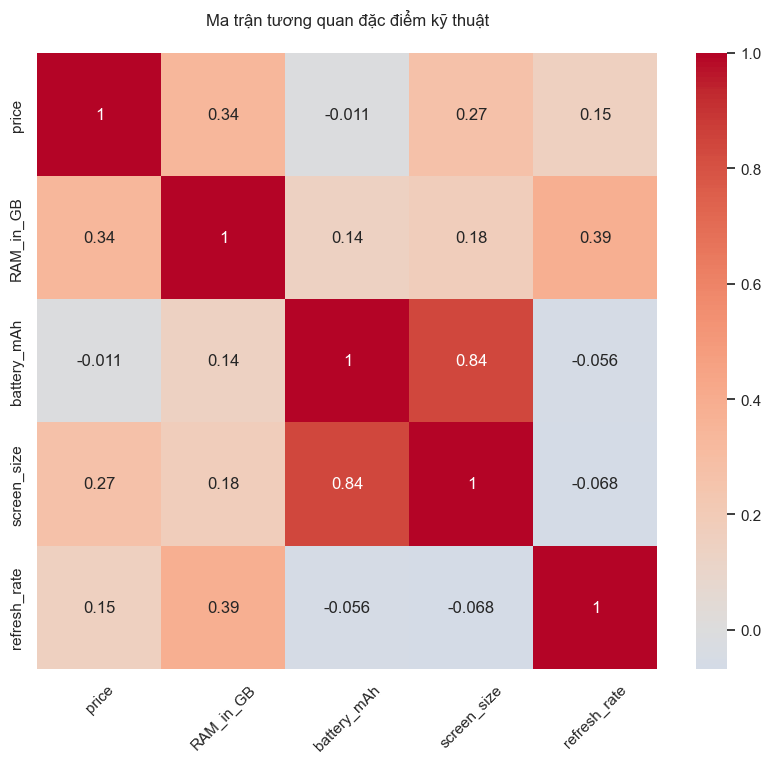

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Thiết lập giao diện đồ họa bằng seaborn
sns.set_theme(style="whitegrid", palette="husl")

# 1. Phân tích tương quan đa biến
numeric_cols = ['price', 'RAM_in_GB', 'battery_mAh', 'screen_size', 'refresh_rate']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Ma trận tương quan đặc điểm kỹ thuật', pad=20)
plt.xticks(rotation=45)
plt.show()
